# Competition Submission

My submission can be found at: https://www.kaggle.com/rmhachar/house-price-predictions-competition-submission

## 1. Setup

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import norm, skew 
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
import lightgbm as lgb
import xgboost as xgb
import os

In [4]:
# read the data sets
training = pd.read_csv('data/train.csv')
testing = pd.read_csv('data/test.csv')
id_col = testing['Id'].values

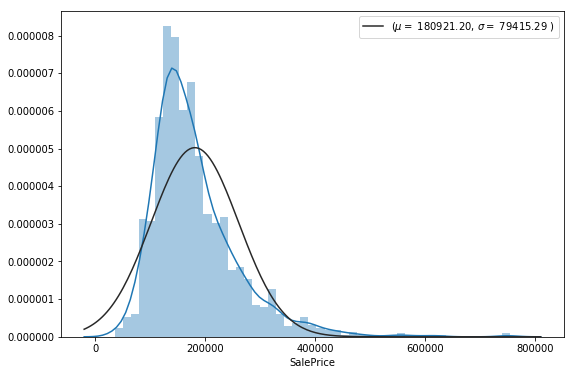

In [5]:
# Plot the target variable to determine its distribu
plt.subplots(figsize=(9,6))
sns.distplot(training['SalePrice'], fit=stats.norm)
(mu, sigma) = stats.norm.fit(training['SalePrice'])
plt.legend(['($\mu=$ {:.2f}, $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

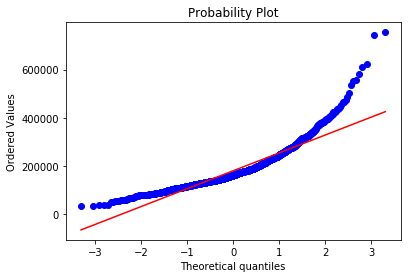

In [6]:
# Display the probability plot
stats.probplot(training['SalePrice'], plot=plt)
plt.show()

In [8]:
# since the prices are skewed, we will have to transform them into a normal distribution
training['LogPrice'] = np.log1p(training['SalePrice'])

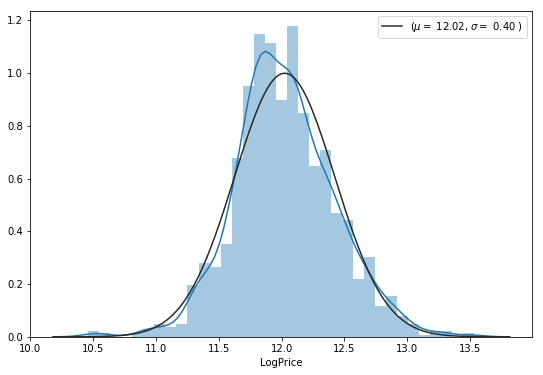

In [9]:
plt.subplots(figsize=(9,6))
sns.distplot(training['LogPrice'], fit=stats.norm)
(mu, sigma) = stats.norm.fit(training['LogPrice'])
plt.legend(['($\mu=$ {:.2f}, $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

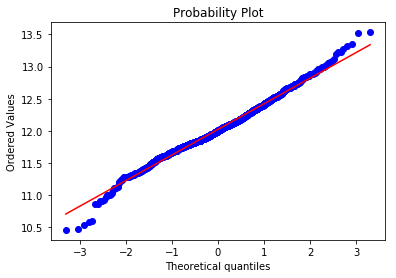

In [11]:
# Display the new probability plot
stats.probplot(training['LogPrice'], plot=plt)
plt.show()

## 3. Training Variables

In [14]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [15]:
training.shape

(1460, 82)

### Missing Variables

Electrical         1
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
BsmtExposure      38
BsmtFinType2      38
GarageCond        81
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
LotFrontage      259
FireplaceQu      690
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64


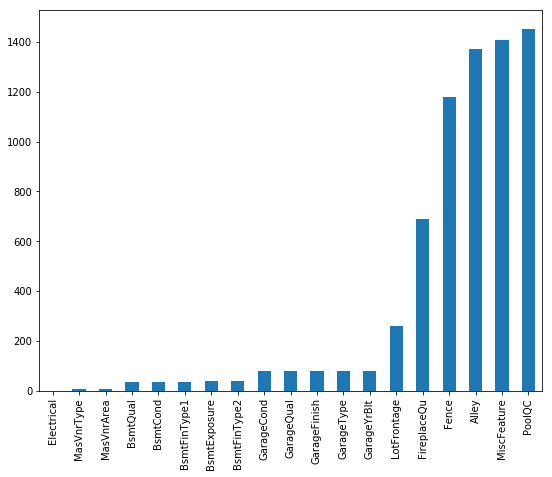

In [16]:
# count and sort missing values
missing = training.isnull().sum()
missing = missing[missing>0]
missing.sort_values(inplace=True)
# display missing data
print(missing)
# vizualize the missing data
missing.plot.bar(figsize=(9,7))

Electrical      0.000685
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtFinType1    0.025342
BsmtExposure    0.026027
BsmtFinType2    0.026027
GarageCond      0.055479
GarageQual      0.055479
GarageFinish    0.055479
GarageType      0.055479
GarageYrBlt     0.055479
LotFrontage     0.177397
FireplaceQu     0.472603
Fence           0.807534
Alley           0.937671
MiscFeature     0.963014
PoolQC          0.995205
dtype: float64


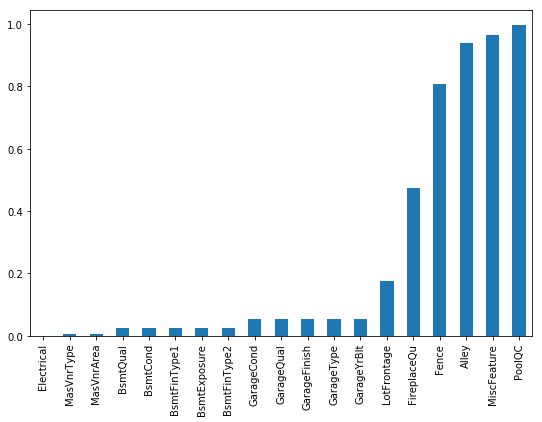

In [17]:
# create ratio of missing values to possible values
missing_ratio = missing/len(training)
# display ratio of values missing
print(missing_ratio)
# plot ratio of values missing
missing_ratio.plot.bar(figsize=(9,6))

In [18]:
missing_50 = missing_ratio[missing_ratio>.5]
missing_50

Fence          0.807534
Alley          0.937671
MiscFeature    0.963014
PoolQC         0.995205
dtype: float64

In [19]:
print("Length before dropping: ", len(training.columns))
for i in missing_50.keys():
    print("Dropping {}".format(i))
    training = training.drop([i], axis=1)
    testing = testing.drop([i], axis=1)
    
print("Length after dropping: ", len(training.columns))

Length before dropping:  82
Dropping Fence
Dropping Alley
Dropping MiscFeature
Dropping PoolQC
Length after dropping:  78


In [21]:
# Fill missing Qualitative Values with 'None'

qualitative_values = [
    'FireplaceQu',
    'GarageType', 
    'GarageFinish', 
    'GarageQual', 
    'GarageCond', 
    'BsmtQual', 
    'BsmtCond', 
    'BsmtExposure', 
    'BsmtFinType1', 
    'BsmtFinType2',
    'MasVnrType',
    'MSSubClass'
]

for i in (qualitative_values):
    training[i] = training[i].fillna('None')
    testing[i] = testing[i].fillna('None')

In [22]:
# Fill missing Quantitative Values with 0

quantitative_values = [
    'GarageYrBlt', 
    'GarageArea', 
    'GarageCars',
    'BsmtFinSF1', 
    'BsmtFinSF2', 
    'BsmtUnfSF',
    'TotalBsmtSF', 
    'BsmtFullBath', 
    'BsmtHalfBath',
    'MasVnrArea'
]

for i in (quantitative_values):
    training[i] = training[i].fillna(0)
    testing[i] = testing[i].fillna(0)   

In [23]:
# Fill in remaining variables with the mode

mode_variables = [
    'MSZoning', 
    'Electrical',
    'KitchenQual', 
    'Exterior1st', 
    'Exterior2nd',
    'SaleType'
]

for i in (mode_variables):
    training[i] = training[i].fillna(training[i].mode()[0])
    testing[i] = testing[i].fillna(testing[i].mode()[0])

In [24]:
# Fill in Functional variable with 'Typ' as suggested by other kernels

training['Functional'] = training['Functional'].fillna('Typ')
testing['Functional'] = testing['Functional'].fillna('Typ')

# Fill in LotFrontage variable with the median value for its neighborhood type
training['LotFrontage'] = training.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))
testing['LotFrontage'] = testing.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

# Drop the Utilities column as each entry is identical
# Drop the ID column as it is unnecessary
training = training.drop(['Utilities','Id'],axis=1)
testing = testing.drop(['Utilities','Id'],axis=1)

In [25]:
# Display the training and testing sets to confirm that there are no remaining null values

testing.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
                ..
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorc

### Label Encoding

In [26]:
# Create a list of variables to encode
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(training[c].values)) 
    training[c] = lbl.transform(list(training[c].values))

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(testing[c].values)) 
    testing[c] = lbl.transform(list(testing[c].values))
print(training.shape)
print(testing.shape)

(1460, 76)
(1459, 74)


In [27]:
# Finally, create a variable for total square footage.
testing['TotalSF'] = testing['TotalBsmtSF'] + testing['1stFlrSF'] + testing['2ndFlrSF']
training['TotalSF'] = training['TotalBsmtSF'] + training['1stFlrSF'] + training['2ndFlrSF']

print(training.shape)
print(testing.shape)

(1460, 77)
(1459, 75)


### Outliers

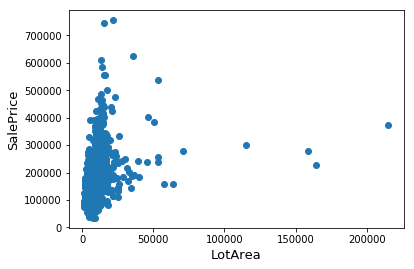

In [28]:
# Outliers are present in the dataset. Plotting Lot Area will reveal this.
plt.scatter(x = training['LotArea'], y = training['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotArea', fontsize=13)
plt.show()

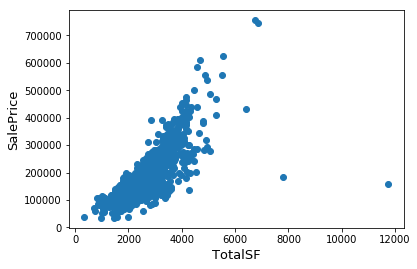

In [29]:
plt.scatter(x = training['TotalSF'], y = training['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('TotalSF', fontsize=13)
plt.show()

In [30]:
# Next, drop the outliers: lots larger than 50,000 square feet, properties with over 7000 square footage of living area, and properties that sold for more than $600,000
training = training.drop(training[(training['LotArea']>50000) | (training['TotalSF'] > 7000) | (training['SalePrice'] > 600000)].index)

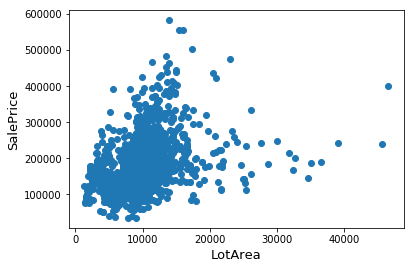

In [31]:
plt.scatter(x = training['LotArea'], y = training['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotArea', fontsize=13)
plt.show()

In [34]:
# More outliers are revealed by this new plot, drop properties with lots larger than 50,000 square feet.
training = training.drop(training[(training['LotArea']>30000)].index)

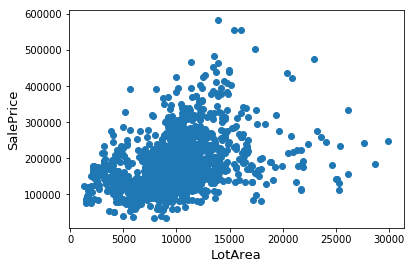

In [35]:
plt.scatter(x = training['LotArea'], y = training['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotArea', fontsize=13)
plt.show()

### Skewed Features

In [36]:
# Display skewed features for training set
train_features = training.dtypes[training.dtypes != "object"].index
# Drop the target variable
train_features = train_features.drop(['LogPrice','SalePrice'])
# Display features
train_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'LotShape',
       'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'TotalSF'],
      dtype='object')

In [47]:
skewed_features = training[train_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness_train = pd.DataFrame({'Skew' :skewed_features})
skewness_train.head(10)

,Skew
MiscVal,24.309074
PoolArea,17.376621
3SsnPorch,10.202849
LowQualFinSF,8.921846
LandSlope,5.137449
KitchenAbvGr,4.479649
BsmtFinSF2,4.280779
ScreenPorch,4.165738
BsmtHalfBath,4.155427
EnclosedPorch,3.070757


In [ ]:
# Now we do the same for test
test_features = testing.dtypes[testing.dtypes != "object"].index
# Display features
test_features

In [46]:
skewed_features = testing[train_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness_test = pd.DataFrame({'Skew' :skewed_features})
skewness_test.head(10)

,Skew
PoolArea,20.176117
MiscVal,20.054543
LowQualFinSF,16.150628
3SsnPorch,12.511336
LandSlope,4.963280
EnclosedPorch,4.664371
KitchenAbvGr,4.074860
BsmtFinSF2,4.038796
ScreenPorch,3.784349
BsmtHalfBath,3.779085


In [49]:
# Unskew Training Variables
skewed_var = skewness_train[abs(skewness_train) > 0.65] 
print("There are {} skewed numerical features to Box Cox transform in the training set".format(skewed_var.shape[0]))
skewed_features = skewed_var.index 
bc_lam = 0.145 
for feat in skewed_features: 
    training[feat] = boxcox1p(training[feat], bc_lam)

There are 56 skewed numerical features to Box Cox transform in the training set


In [50]:
# Unskew Training Variables
skewed_var = skewness_test[abs(skewness_test) > 0.65] 
print("There are {} skewed numerical features to Box Cox transform in the testing set".format(skewed_var.shape[0]))
skewed_features = skewed_var.index 
bc_lam = 0.145 
for feat in skewed_features: 
    testing[feat] = boxcox1p(testing[feat], bc_lam)

There are 56 skewed numerical features to Box Cox transform in the testing set


In [51]:
training_temp = training.drop(['SalePrice','LogPrice'],axis=1)
print("Testing Shape: ", testing.shape)
print("Training Shape: ", training.shape)
print("Training Temporary Shape: ", training_temp.shape)

Testing Shape:  (1459, 75)
Training Shape:  (1435, 77)
Training Temporary Shape:  (1435, 75)


### Combining Data for Encoding Dummy Variables